1. Questions and problem definition
2. Load and understand data
3. data clean ( correcting, completing, creating, and converting)
4. eda
5. feature engineering
6. model

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import random as rand

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing

import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
import colorlover as cl

pyo.init_notebook_mode(connected=True)

In [47]:
# Load the data
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(train_df.shape)
print(train_df.dtypes)

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


# Clean data

In [6]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Lets try to fill in some missing data. Cabin doesn't provide much information so ultimately it'll be dropped as a whole. The Age feature on the other hand could be important following the logic that people would attempt to save the young. Also throwing away any rows with the Age missing would be about 20% of the training data.
 

In [54]:
# Encode categorical features for training
def encode_feature(x, classes):
    le = preprocessing.LabelEncoder()
    # NaN values must be converted to strings
    if any(x.isna()) and isinstance(x[0], str):
        classes += ["NaN"]
        x = x.fillna("NaN")
    le.fit(classes)
    return le.transform(x)

def create_dummies(variables, possibilities):
    save_index = variables.index
    unique_variables= set(variables)
    difference = pd.Series(list(set(possibilities) - unique_variables))
    target = variables.append(pd.Series(difference))
    target = target.reset_index(drop=True)
    dummies = pd.get_dummies(target)
    dummies = dummies.drop(dummies.index[list(range(len(dummies)-len(difference), len(dummies)))])
    dummies.index = save_index
    return dummies

train_df["Sex_encoded"] = encode_feature(train_df["Sex"], ["female", "male"])
train_df["Embarked_encoded"] = encode_feature(train_df["Embarked"], list(set(train_df["Embarked"].dropna())))

What I learned:

Different approach to encoding ordinal or cateogircal feature

# Features

* PassengderId - unique id for each passenger
* Survived - class label
* Pclass - passenger class
* Name - name of passenger
* Sex - gender
* Age - year old
* Sibsp - total number of siblings and spouses
* Parch - # parents or children aboard
* Ticket - ticket number
* Fare - ticket price
* Cabin - room number
* Embarked - port

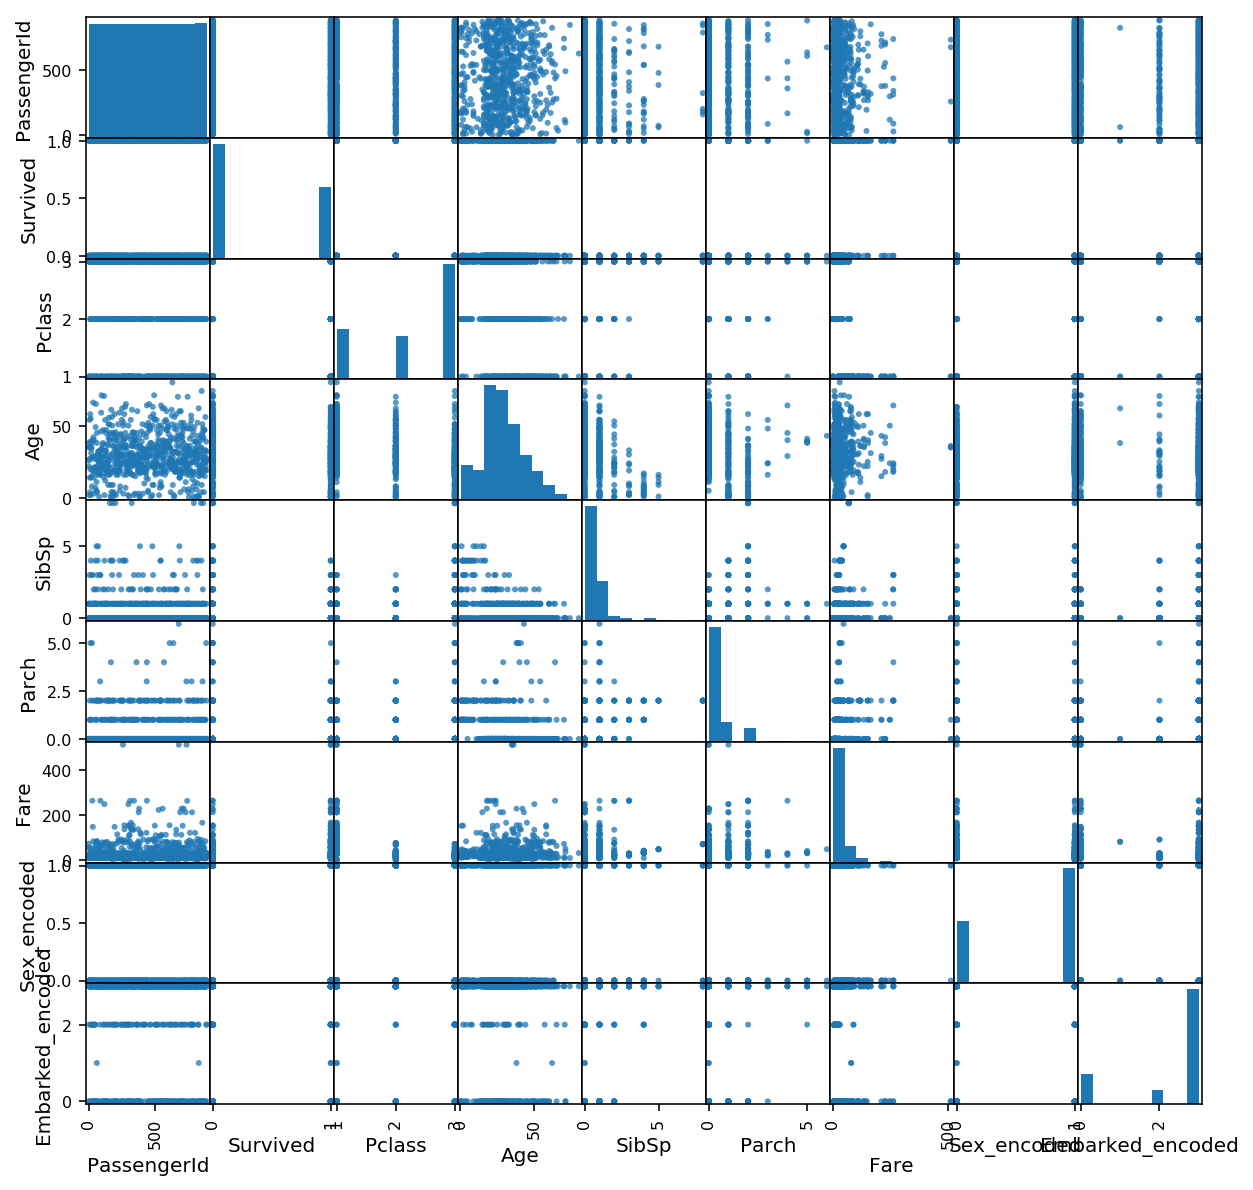

In [49]:
pd.plotting.scatter_matrix(train_df, alpha=0.75, figsize=(10,10))
plt.show()

Basic scatter matrix isn't very useful because of the data type so lets craft graphs for each feature.

In [50]:

def eda_analysis(df):
    age_hist_data = [go.Histogram(
        x=df[(df.Survived==alive)]["Age"],
        opacity=0.75,
        name= "Survived" if alive == 1 else "Died",
        nbinsx= 50
    ) for alive in [0, 1]]
    age_hist_layout = go.Layout(
        xaxis=dict(title="Age"),
        barmode="overlay"
    )
    age_hist_fig = go.Figure(data=age_hist_data, layout=age_hist_layout)
    pyo.iplot(age_hist_fig)
    
    embark_df = df.pivot_table(index="Embarked", columns="Survived", values="Age", aggfunc="count")
    embark_heat_data = [go.Heatmap(
        z=embark_df.values,
        x=["Died", "Survived"],
        y=embark_df.index.values,
        colorscale="Reds"
    )]
    embark_heat_layout = go.Layout(
        yaxis=dict(title="Embarked")
    )
    embark_heat_fig = go.Figure(data=embark_heat_data, layout=embark_heat_layout)
    pyo.iplot(embark_heat_fig)
    
    fare_hist_data = [go.Histogram(
        x=df[(df.Survived==alive)]["Fare"],
        opacity=0.75,
        name= "Survived" if alive == 1 else "Died"
    ) for alive in [0, 1]]
    fare_hist_layout = go.Layout(
        xaxis=dict(title="Fare"),
        barmode="overlay"
    )
    fare_hist_fig = go.Figure(data=fare_hist_data, layout=fare_hist_layout)
    pyo.iplot(fare_hist_fig)
    
    parch_bar_data = [go.Bar(
        x=df[(df.Survived==alive)]["Parch"].unique(),
        y=df[(df.Survived==alive)]["Parch"].value_counts().sort_index().values,
        name= "Survived" if alive == 1 else "Died"
    ) for alive in [0, 1]]
    
    parch_bar_layout = go.Layout(
        barmode="stack",
        xaxis=dict(title="Parch")
    )
    parch_bar_fig = go.Figure(data=parch_bar_data, layout=parch_bar_layout)
    pyo.iplot(parch_bar_fig)
    
    sibsp_data = [go.Bar(
        x=df[(df.Survived==alive)]["SibSp"].unique(),
        y=df[(df.Survived==alive)]["SibSp"].value_counts().sort_index().values,
        name= "Survived" if alive == 1 else "Died"
    ) for alive in [0, 1]]
    
    sibsp_layout = go.Layout(
        barmode="stack",
        xaxis=dict(title="SibSp")
    )
    sibsp_fig = go.Figure(data=sibsp_data, layout=sibsp_layout)
    pyo.iplot(sibsp_fig)
    
    pclass_data = [go.Bar(
        x=df.Pclass.unique(),
        y=df[(df.Survived==alive)]["Pclass"].value_counts().sort_index().values,
        name= "Survived" if alive == 1 else "Died"
    ) for alive in [0, 1]]
    pclass_layout = go.Layout(
        barmode="stack",
        xaxis=dict(title="Passenger Class")
    )
    pclass_fig = go.Figure(data=pclass_data, layout=pclass_layout)
    pyo.iplot(pclass_fig)
    
    sex_data = [go.Bar(
        x=[0, 1],
        y=df[(df.Survived==alive)]["Sex"].value_counts().sort_index().values,
        name=("Survived" if alive == 1 else "Died")
    ) for alive in [0, 1]]
    sex_layout = go.Layout(
        barmode="stack",
        xaxis=dict(title="Sex")
    )
    sex_fig = go.Figure(data=sex_data, layout=sex_layout)
    pyo.iplot(sex_fig)
    

eda_analysis(train_df)

Interesting observations

More likely to survive if:
* age < 15 or 50 < age < 60
* higher fare
* had a parch of 2
* higher pclass
* female

# Feature Engineering

In [51]:
# Age -> Age Stage
def fe_age_stage(age):
    stage_names = ["missing", "infant", "toddler", "child", "pre-teen", "teen", "adult", "middle age", "old age"]
    stage_cutoff = [-1,0, 1, 3, 10, 14, 18, 45, 65, 100]
    age_stage = pd.cut(age, stage_cutoff, labels=stage_names)
    return age_stage

# Name -> title
def fe_title(names):
    title = []
    for name in names:
        last, first = name.split(',')
        if '.' in first:
            title.append(first.strip().split('.')[0])
        else:
            title.append("None")
    return title        

In [61]:
all_titles = list(set(fe_title(pd.concat([train_df["Name"], test_df["Name"]]))))
train_df["Title"] = fe_title(train_df["Name"])
train_df["Stage"] = fe_age_stage(train_df["Age"])
train_df["Title_encoded"] = encode_feature(train_df["Title"], list(set(train_df["Title"])))
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_encoded,Embarked_encoded,Title,Stage,Title_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,3,Mr,adult,11
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,Mrs,adult,12
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,3,Miss,adult,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,3,Mrs,adult,12
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,3,Mr,adult,11


Inutition tells me title, sibsp, and parch can infer age.

In [57]:
colorscale = cl.scales['11']['qual']['Set3']
title_colors = cl.interp(colorscale, len(set(train_title)) )
title_colorscale = {t:c for t, c in zip(set(train_title), title_colors)}

data = [go.Scatter(
    x=train_df[~train_df.Age.isna()]["Age"],
    y=train_df[~train_df.Age.isna()]["Parch"],
    text=[f"SibSp: {n}" for n in train_df[~train_df.Age.isna()]["SibSp"]],
    mode="markers",
    marker=dict(
        color=[title_colorscale[t] for t in train_df[~train_df.Age.isna()]["Title"]],
        size=(train_df[~train_df.Age.isna()]["SibSp"]+1) * 10)
)]

layout = go.Layout(
    yaxis=dict(title="Parch"),
    xaxis=dict(title="Age")
)

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

Lets try to fill in missing age by predicting with linear regression

In [121]:
# Predict raw age
feature_cols = ["Survived", "SibSp", "Parch", "Sex_encoded", "Title_encoded"]

age_train_df = train_df[~train_df.Age.isna()]
X = age_train_df[feature_cols]
y = age_train_df["Age"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
print("Ordinal encoding: ", regression_model.score(X_test, y_test))

X = pd.concat([X, create_dummies(age_train_df["Title"], all_titles)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
print("One-hot encoding: ", regression_model.score(X_test, y_test))

Ordinal encoding:  0.19677943332601877
One-hot encoding:  0.35444912139163764


Intesting point encoding title vs creating dummy varaibles for linear regression. I assume creating dummy variables for linear regression give more varialbes in equation while encoding title changes coefficient on the single variable.

Predicting raw age isn't very accurate. Lets bin the ages because in terms of developement the difference between a 5 and 7 or 20 and 30 year old is negilibe. So we will create a new feature from binning ages and use a decision tree to classify the age_stage.

In [122]:
# Predict age stage
y = age_train_df["Stage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.659217877094972


65% isn't bad so we will use stage for missing values of age. Now with a new feature that's proxy for age, let's try to use a classifier to fill in stage for rows with missing age valuse.

In [101]:
# Retrain on all the data
clf = clf.fit(X, y)

In [103]:
# Fill in stage for missing ages
missing_age_df = train_df[train_df.Age.isna()]

train_df["Stage"] = train_df.Stage.fillna(pd.Series(index=X.index, data=clf.predict(missing_age_df[feature_cols])))

# Build Naive Bayes, Logistic Regression Model

In [162]:
def train_logistic_regression(x_train, y_train):
    lrm = LogisticRegression()
    lrm.fit(x_train, y_train)
    return lrm

age_stages = ["missing", "infant", "toddler", "child", "pre-teen", "teen", "adult", "middle age", "old age"]
train_df["Stage_encoded"] = encode_feature(train_df["Stage"], age_stages)
feature_cols = ["Fare", "Pclass", "Sex_encoded", "SibSp", "Parch", "Stage_encoded"]
# full_train_df = pd.concat([train_df, encode_dummies(train_df.Title, all_titles), encode_dummies(train_df.Stage, stage_names)], axis=1)
# drop_cols = ["PassengerId", "Name", "Ticket", "Title", "Stage", "Age", "Embarked", "stage"]
# full_train_df = full_train_df.drop(drop_cols, axis=1)
X = train_df[feature_cols]
y = train_df.Survived


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
lrm_fitted = train_logistic_regression(X_train, y_train)

/home/leon/miniconda3/envs/base_datasci/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [163]:
y_pred = lrm_fitted.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[113,  15],
       [ 34,  61]])

In [164]:
data = [go.Heatmap(
    z=cnf_matrix[::-1],
    x=["Died", "Survived"],
    y=["Suvived", "Died"],
)]

layout = go.Layout(
    yaxis=dict(title="Acutal label"),
    xaxis=dict(title="Predicted label")
)

fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig)

In [165]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7802690582959642
Precision: 0.8026315789473685
Recall: 0.6421052631578947


In [184]:
y_score = lrm_fitted.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test, y_score)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


lw = 2

trace1 = go.Scatter(x=fpr[0], y=tpr[0], 
                    mode='lines', 
                    line=dict(color='darkorange', width=lw),
                    name='ROC curve (area = %0.2f)' % roc_auc[0]
                   )

trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                    mode='lines', 
                    line=dict(color='navy', width=lw, dash='dash'),
                    showlegend=False)

layout = go.Layout(title='Receiver operating characteristic example',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=[trace1, trace2], layout=layout)
pyo.iplot(fig)


# Naive Bayes Classifier

In [166]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb = GaussianNB()
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [167]:
y_pred = gnb.predict(X_test)
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          X_test.shape[0],
          (y_test != y_pred).sum(),
          100*(1-(y_test != y_pred).sum()/X_test.shape[0])
))

Number of mislabeled points out of a total 223 points : 51, performance 77.13%


# Decision Tree

In [168]:
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7757847533632287
